# CNN for Sound Classification 
Classifes the source of a sound as either a real instrument or a digital synthisizer. 
Inputs are mel-spectrograms generated from 3 second sound clips. 
In a given clip there is exactly one source, instrument or otherwise, at a time.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

mainDataFolder = "/content/drive/My Drive/ColabData"

#load dataset
dataSet = np.load(mainDataFolder + "/Dataset/dataset2.npy", allow_pickle=True)


Divide in to 3 sets, training, development, and testing.

In [ ]:

xtrain = []
ytrain = []
xdev = []
ydev = []
xtest = []
ytest = []

dataIndex = 0

# Here I build each set in a single pass getting 
# each set an evenly distributed representation of the data.
# This is becuase data points in this set are often similiar to their 
# neighbors.

for features, label in dataSet:
  n = dataIndex % 10 
  if(n < 8):
    xtrain.append(features)
    ytrain.append(label)
  elif(n < 9):
    xdev.append(features)
    ydev.append(label)
  else:
    xtest.append(features)
    ytest.append(label)
  dataIndex += 1

In [ ]:
from numpy.random import shuffle
  
# Shuffel the sets individually.
# Setting same seed before shuffling x and y ensures correct labeling is maintained.
seed = 0

np.random.seed(seed)
shuffle(xtrain)
np.random.seed(seed)
shuffle(ytrain)

np.random.seed(seed + 1)
shuffle(xdev)
np.random.seed(seed + 1)
shuffle(ydev)

np.random.seed(seed + 2)
shuffle(xtest)
np.random.seed(seed + 2)
shuffle(ytest)


In [ ]:
# Shape and normalize 
xtrain = np.array(xtrain).reshape(-1,128,128,1)
xdev = np.array(xdev).reshape(-1,128,128,1)
xtest = np.array(xtest).reshape(-1,128,128,1)

xtrain = xtrain / 255
xdev = xdev / 255
xtest = xtest / 255

ytrain  = np.asarray(ytrain)
ydev = np.asarray(ydev)
ytest = np.asarray(ytest)

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
 
model.add(Conv2D(16, (3, 3),activation = 'relu', input_shape=xtrain[0, :, :, :].shape))
model.add(Conv2D(4, (3, 3), activation = 'relu' ))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))
 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 16)      160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 4)       580       
_________________________________________________________________
flatten_2 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 61504)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61505     
Total params: 62,245
Trainable params: 62,245
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
model.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history = model.fit( xtrain, ytrain, validation_data = (xdev, ydev), epochs = 80, batch_size = 32, callbacks=[mc], verbose=0)

In [ ]:
from tensorflow.keras.models import load_model
from IPython.display import clear_output

saved_model = load_model('best_model.h5')
# evaluate the saved model
_, train_best = saved_model.evaluate(xtrain, ytrain, verbose=0)
_, dev_best = saved_model.evaluate(xdev, ydev, verbose=0)
_, test_best = saved_model.evaluate(xtest, ytest, verbose=0)

# compare to the final model
train_model = model.evaluate(xtrain,ytrain, verbose=0)
dev_model = model.evaluate(xdev,ydev, verbose=0)
test_model = model.evaluate(xtest,ytest, verbose=0)

clear_output()

print("Saved Model: ")
print("Train: %.2f Dev: %.2f Test: %.2f" % (train_best*100, dev_best*100, test_best*100))

print("\nFinal Model: ")
print("Train: %.2f Dev: %.2f Test: %.2f" % (train_model[1]*100,dev_model[1]*100,test_model[1]*100))

Saved Model: 
Train: 100.00 Dev: 97.17 Test: 99.06

Final Model: 
Train: 100.00 Dev: 97.17 Test: 98.11


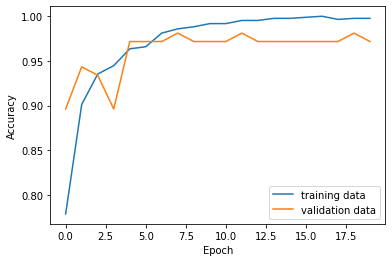

In [ ]:
plt.plot(history.history['accuracy'][:20])
plt.plot(history.history['val_accuracy'][:20])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

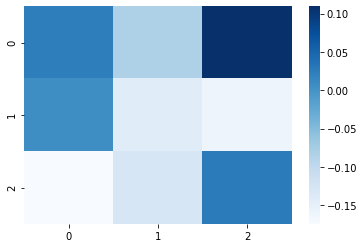

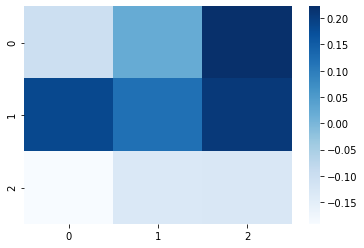

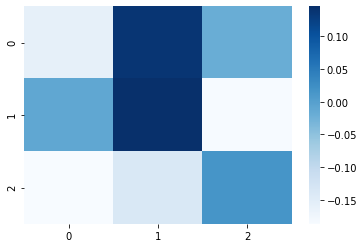

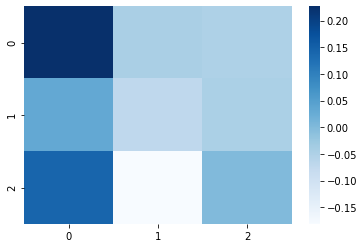

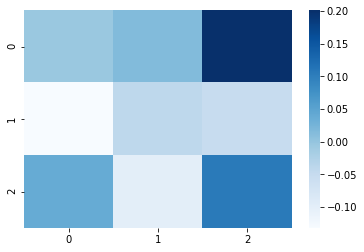

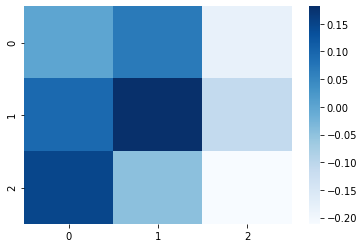

In [ ]:
# Pull out some weights from the filter
import seaborn as sns
filter_weights = model.get_weights()[0]
for i in range(0,6):
  sns.heatmap(filter_weights[:, :, 0, i], cmap='Blues')
  plt.show()